In [51]:
#IDEAS
#https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html
#http://sbfnk.github.io/mfiidd/mcmc_diagnostics.html
#https://cran.r-project.org/web/packages/ggmcmc/vignettes/v70i09.pdf

# Advance Statistics for physical analysis project:

# Study of the energy resolution and uncertainties of germanium detectors using bayesian methods


<b>Students</b> : 
   
   - Hilario Capettini
   - João Freitas 
    
<b>Professor</b> :
   
   - Alberto Garfagnini

# Theory

We have a file containing counts for different channels. These counts were obtained with a Germanium detector irradiated by a combination of three sources $^{241}\text{Am}$, $^{60}\text{Co}$, $^{137}\text{Cs}$. 

Our goal is to characterize the peaks of the signal assigning to them a position $x_i$, a width $w_i$, an amplitude $A_i$ and also to decouple them from the noise characterizing it with an amplitude $B_i$, the subindex $i=1,...,n$ implies that these quantities are specific for each peak in the signal. 

So, given the counts $\{N_k\}$ measured at the values $\{x_k\}$ we want the best estimates for $x_i, \; w_i, \; A_i, \; B_i$ characterizing the noise and the signal peaks. 
In this case we have a photon spectrum were the number of photons was measured by bins of energy. This number is proportional to the exposure $\Delta t$ (the time that we have been measuring) and the other variables that we are considering through the following formula:

$$ S_k = \Delta t \left[A \text{exp}\left(-\frac{(x_k-x_0)^2}{2 w^2}\right)+B\right]  $$

The number of observed photons, $\lambda$, is an integer number and follows the Poisson distribution

$$P(\lambda|S)= \frac{S^\lambda e^{-S}}{\lambda!}$$

as each event is independent from the others, we can obtain the likelihood just by multiplying the Poisson distribution

$$P(D|\theta,M)= \prod_j \frac{S_k^{\lambda_k}e^{-S_k}}{\lambda_k!} $$

were we are using $\theta=(A,B,w,X_0)$

In [52]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
library(tidyverse)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

# Data loading and visualization

## Loading

In [53]:
data <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 
#r_data <- read.csv("data/IC48A_AmCsCo.txt",header=TRUE, sep="\t")

#Data must be passed in list form
#data  <- NULL
#data$x <- r_data[[1]]  
#data$y <- r_data[[2]]

## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

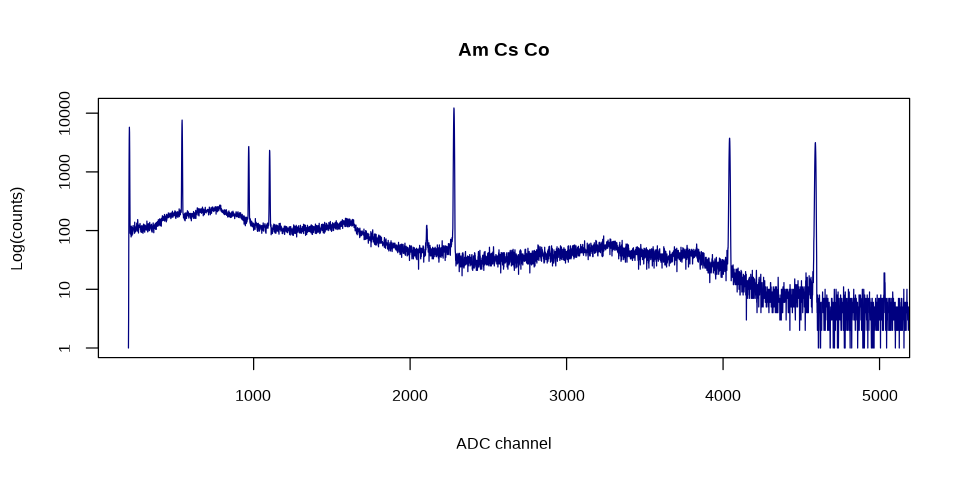

In [54]:
set_plot_dimensions(8, 4)

plot(data$Ch,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## Additional  Information

In [55]:
#Add tble with the energies and so on, all what we will be needing/using along the notebook
#and is external

## Peak detection and characterization

In [6]:
#Integrate Joaos function to detect and characterize the peaks.
#We basically need invervals containing the peaks and their maximums.

In [56]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}

peak_shift <- function(peak_array){
    #fetches an array of counts with the peak at the center
    peak_idx <- which.max(peak_array)
    peak_y <- c(peak_array[(peak_idx-10):(peak_idx+10)])
    return(peak_y)
}

fetch_ch <- function(peak_array){
    #fetches indices of a particular peak as it exists in the elements of data_range
    peak_idx <- which.max(peak_array)
    idx_c <- c((peak_idx-10):(peak_idx+10))
    return(idx_c)
}

probe_peaks <- function(data, n.pts, pk_size){
    
    #split counts and channels into intervals of n.pts each
    data_range <- split(data$counts, ceiling(row(data)/n.pts))
    ch_range <- split(data$Ch, ceiling(row(data)/n.pts))
    
    #find the range of values for each interval established in data_range
    minmax_range <- lapply(data_range, range_size)
    
    #filter the counts to return peaks larger than a certain size.
    peaks <- data_range[minmax_range > pk_size]
    
    #applies functions to gather counts in each of the peaks, and their indices in data_range
    ly <- lapply(peaks, peak_shift)
    lx <- lapply(peaks, fetch_ch)
    
    #build dataframe of channel indices
    centered_ch <- bind_cols(lx)
    colnames(centered_ch) = paste('X', 1:length(lx), sep = '')
    
    #convert indices gathered from data_range to channel values according to ch_range
    for(i in seq_along(colnames(centered_ch))){
        centered_ch[[colnames(centered_ch)[i]]] = ch_range[[names(lx)[i]]][lx[[i]]]
    }
    
    #build dataframe of count values
    centered_peaks <- bind_cols(ly)
    colnames(centered_peaks) = paste('Y',1:length(ly), sep = '')
    
    #bind together channel values and count values, with "Xi" corresponding to "Yi", i = 1, 2, ...
    centered_ch %<>% cbind(centered_peaks)
    return(centered_ch)
}

centered_peaks <- probe_peaks(data, 80, 3500)

Warning message in split.default(data$counts, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”Warning message in split.default(data$Ch, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”

In [57]:
centered_peaks 

X1,X2,X3,X4,Y1,Y2,Y3,Y4
196,533,2270,4032,0,221,72,50
197,534,2271,4033,0,204,76,74
198,535,2272,4034,1,227,96,128
199,536,2273,4035,0,230,108,239
200,537,2274,4036,1,205,219,434
201,538,2275,4037,3,256,586,777
202,539,2276,4038,48,547,1400,1528
203,540,2277,4039,328,1570,3304,2232
204,541,2278,4040,1458,3904,6290,3065
205,542,2279,4041,3690,6510,9826,3683


In [58]:
#Working intervals
#Peak one   x0 [200:220]
#Peak two   x0 [530:560]
#Peak three x0 [900:1000] Atention with the amplitude A[2000:3000]
#Peak four x0 [1080:1120] Atention with the amplitude A[2000:3000]

In [6]:
#We reduce the data to the vicinity of the choosen peak
peak_1.data <- NULL
peak_1.data$x <- data$Ch[1080:1120] 
peak_1.data$y <- data$counts[1080:1120]

# Peak processing 

## Peak display

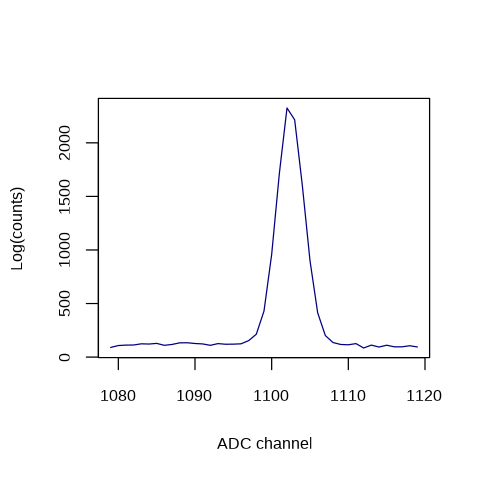

In [7]:
#Plot of the choosen peak
set_plot_dimensions(4, 4)

plot(peak_1.data$x,peak_1.data$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel")

## BUGS model

In [8]:
#The model is defined in a .bug (txt) file
#To easily modify the intervals we manage it from the notebook

#The interval for the priors are very importants!
a<-2000
b<-3000
cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dunif(",a,",",b,")
    B ~ dunif(0,600)

    x0 ~ dunif(1080,1120)
    w ~ dunif(1,10)
      
}", file="Models/model_1.bug")

model <- "Models/model_1.bug"

## Convergence studies 

### Chain initializations

In [9]:
#If multiple chains are run, each of them need to be initialized
init_1_1 <- NULL;init_1_1$A  <- 2500;  init_1_1$B  <- 0;   init_1_1$w  <- 5; init_1_1$x0 <- 1100
init_1_2 <- NULL;init_1_2$A  <- 2500;  init_1_2$B  <- 100; init_1_2$w  <- 5; init_1_2$x0 <- 1100
init_1_3 <- NULL;init_1_3$A  <- 2500; init_1_3$B  <- 200; init_1_3$w  <- 5; init_1_3$x0 <- 1100

#To have absolute control we also set the seed for and random number generator for each chain
init_1 <- list(c(init_1_1,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init_1_2,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init_1_3,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"))


### Run JAGS

In [10]:
chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10

In [11]:
jm <- jags.model(model,
                 peak_1.data,
                 inits=init_1,
                 n.chains=chain_number)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 4
   Total graph size: 384

Initializing model



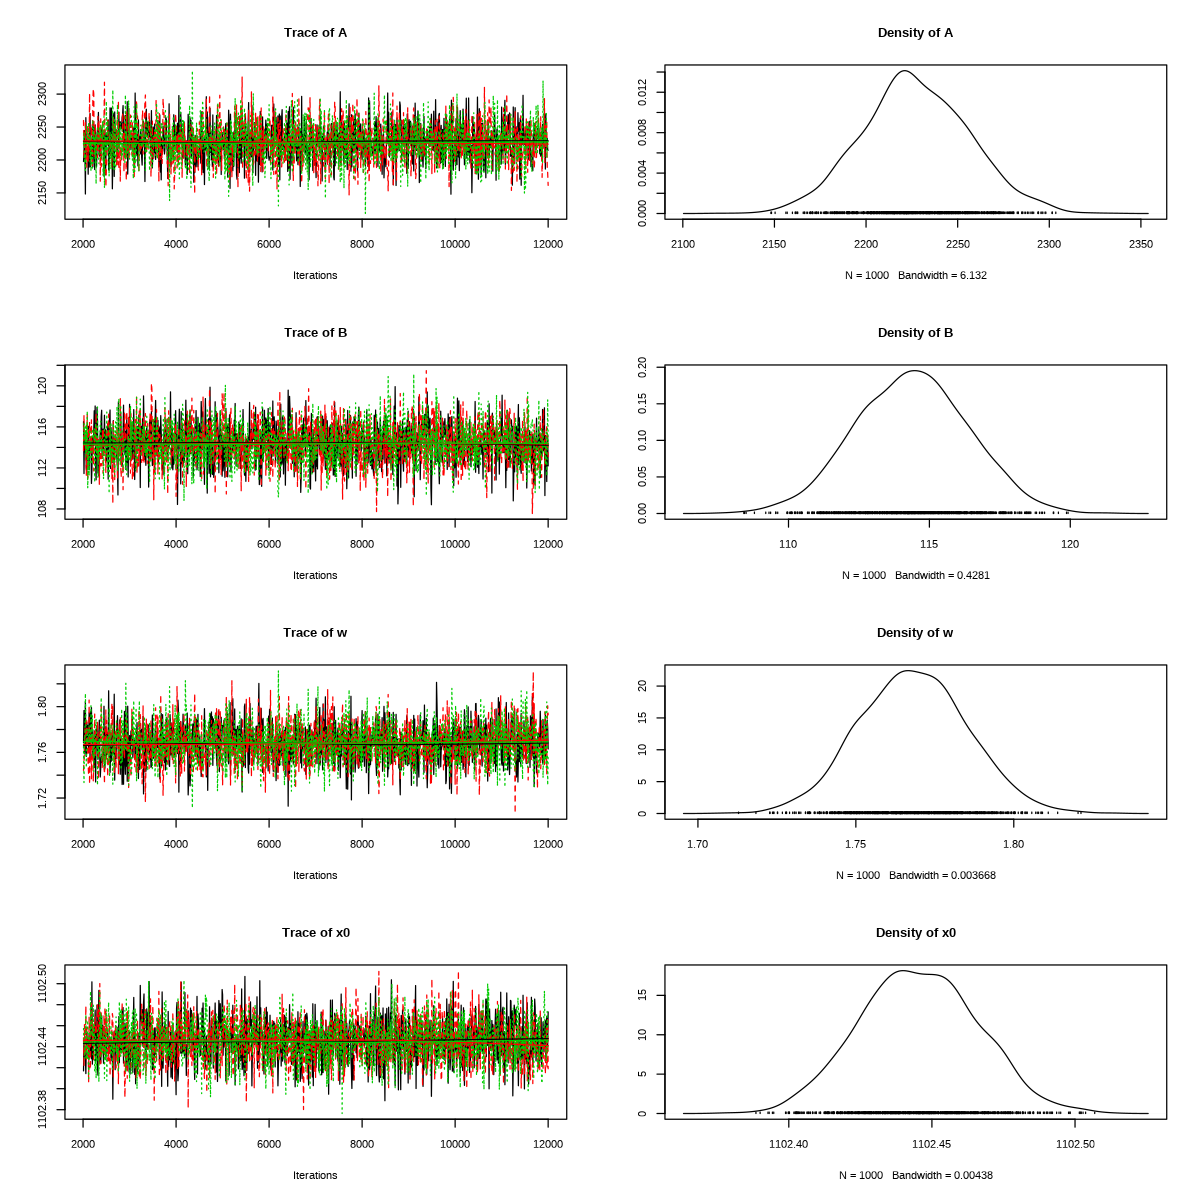

In [12]:
#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
plot(chain)

### Chain autocorrelation

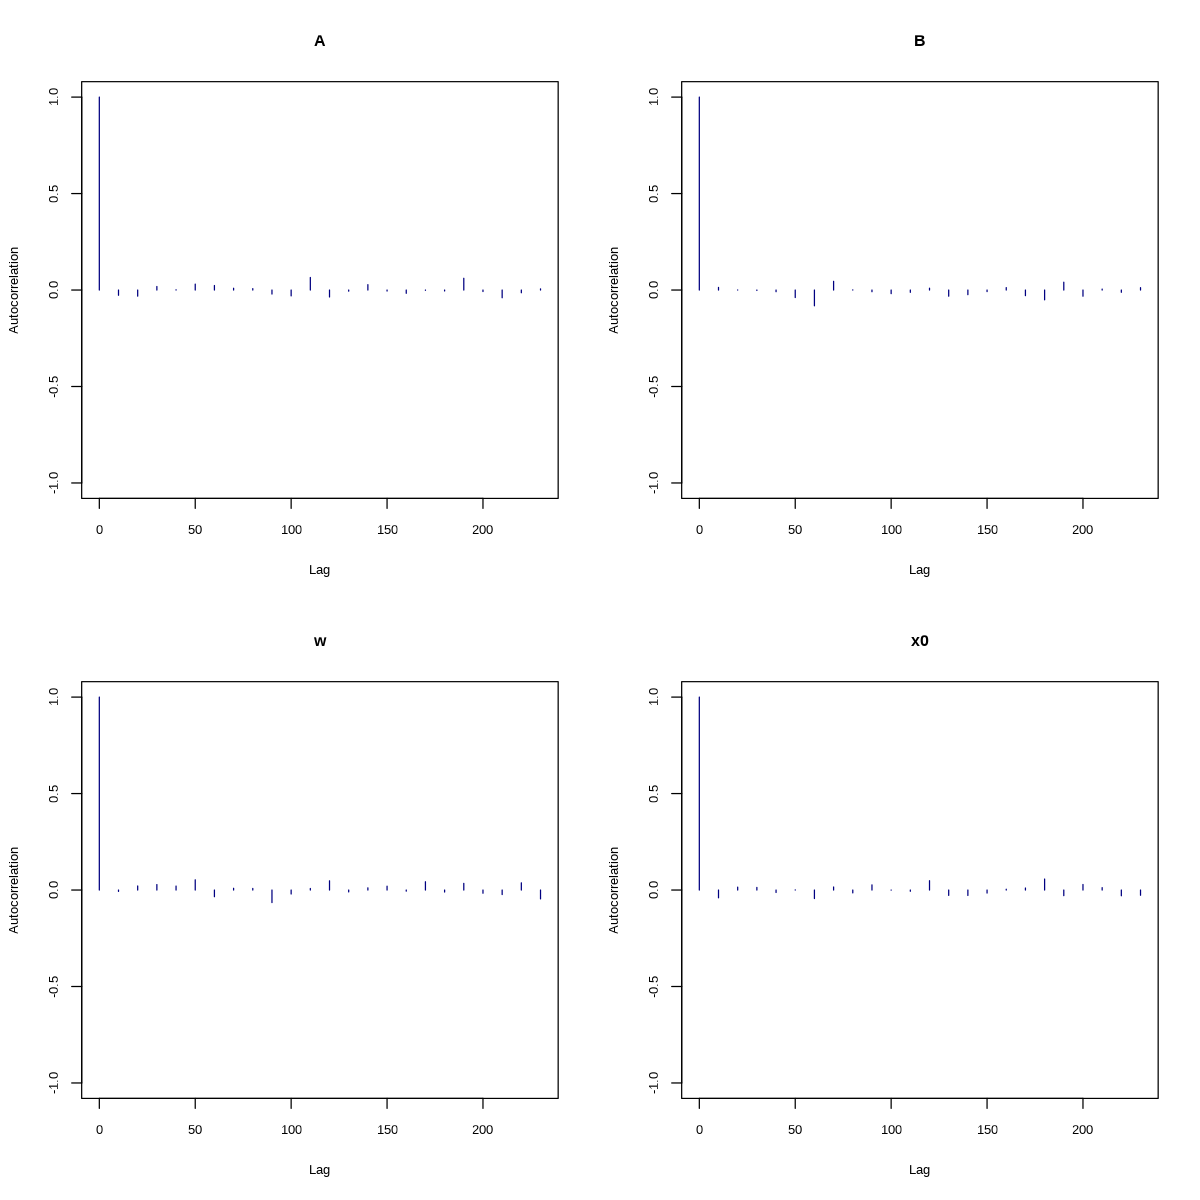

In [13]:
#Autocorrelation plots
autocorr.plot(chain[[1]], col='navy')

### Burn-in effect on autocorrelation

### Thining effect on autocorrelation

### Parameter correlations

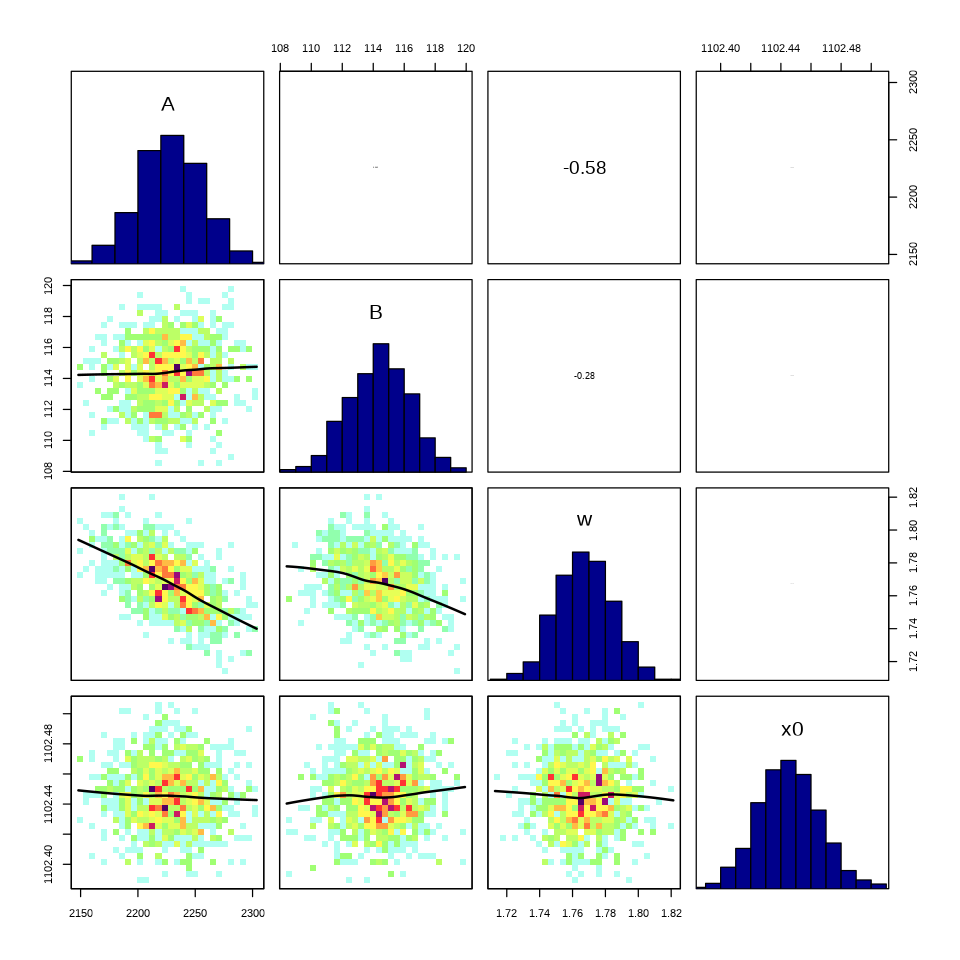

In [14]:
set_plot_dimensions(8, 8)
correlationPlot((chain))

### Gelman diagnostic of the multiple chains

Potential scale reduction factors:

   Point est. Upper C.I.
A           1       1.01
B           1       1.00
w           1       1.01
x0          1       1.00

Multivariate psrf

1

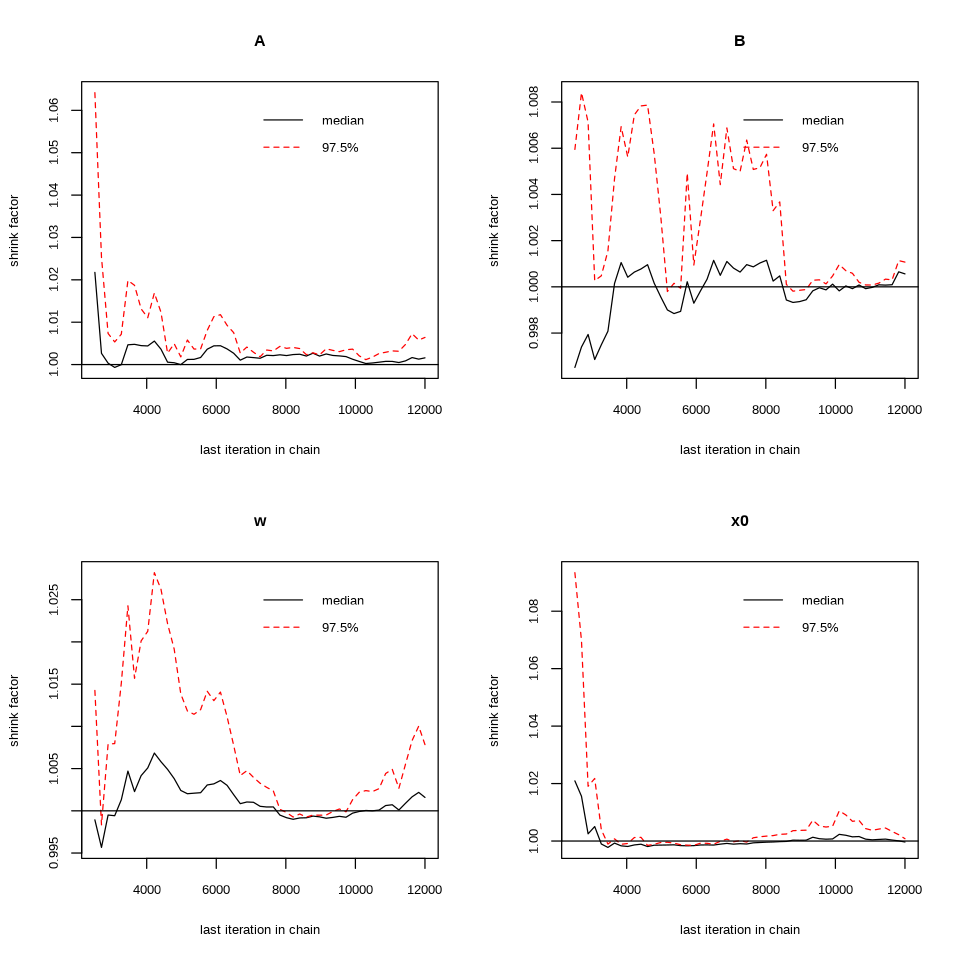

In [15]:
gelman.diag(chain)
gelman.plot(chain)

### MCMC results for the parameters

In [16]:
summary(chain)


Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  2227.038 29.23865 0.5338223      0.5338769
B   114.376  2.00285 0.0365669      0.0365784
w     1.768  0.01716 0.0003133      0.0003132
x0 1102.445  0.02049 0.0003741      0.0003742

2. Quantiles for each variable:

       2.5%      25%      50%     75%    97.5%
A  2169.955 2208.225 2225.953 2246.67 2286.274
B   110.441  112.986  114.385  115.71  118.223
w     1.735    1.756    1.768    1.78    1.802
x0 1102.406 1102.431 1102.445 1102.46 1102.485


### Distributions and confidence intervals

In [17]:
#write code to obtain some bar plots under the pdf and lines stating the confidence intervals
#
#
#

### Results presentation

In [18]:
#Table with the results
#
#
#

In [19]:
A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x <- seq(1080,1120,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)

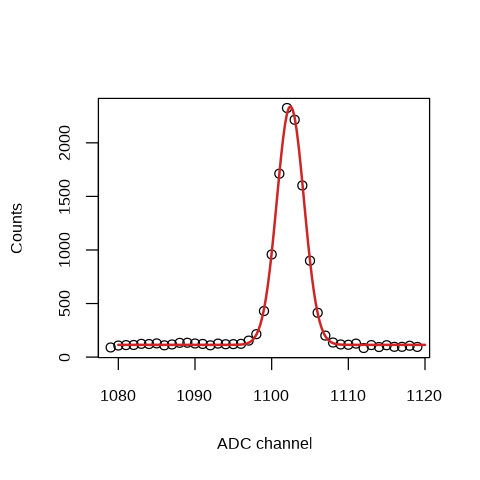

In [20]:
set_plot_dimensions(4, 4)

plot(peak_1.data$x,peak_1.data$y,
    ylab = "Counts", xlab ="ADC channel")
lines(x,f, lwd=2, col='firebrick3')

In [21]:
#Working intervals
#Peak one   x0 [200:220]
#Peak two   x0 [530:560]
#Peak three x0 [900:1000] Atention with the amplitude A[2000:3000]
#Peak four x0 [1080:1120] Atention with the amplitude A[2000:3000]

#Symetric intervals around the peaks are the ones working better

In [49]:
t1 <- NULL
t1$x <- centered_peaks$X1[centered_peaks$Y1!=0]
t1$y <- centered_peaks$Y1[centered_peaks$Y1!=0]

t2 <- NULL
t2$x <- centered_peaks$X2
t2$y <- centered_peaks$Y2

t3 <- NULL
t3$x <- centered_peaks$X3
t3$y <- centered_peaks$Y3

t4 <- NULL
t4$x <- centered_peaks$X4
t4$y <- centered_peaks$Y4


peaks <-list(t1,t2,t3,t4)

In [59]:
t1 <- NULL
t1$x <- data$Ch[203:220]
t1$y <- data$counts[203:220]

t2 <- NULL
t2$x <- data$Ch[530:560] 
t2$y <- data$counts[530:560]

t3 <- NULL
t3$x <- data$Ch[960:980] 
t3$y <- data$counts[960:980]

t4 <- NULL
t4$x <- data$Ch[1080:1120]
t4$y <- data$counts[1080:1120]


peaks <-list(t1,t2,t3,t4)

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
A  5675.031 45.858630 0.8372602      0.8528842
B    91.977  2.406966 0.0439450      0.0439444
w     1.269  0.007455 0.0001361      0.0001362
x0  206.184  0.010109 0.0001846      0.0001799

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  5578.137 5644.723 5677.202 5710.636 5750.570
B    86.881   90.288   92.197   93.912   95.710
w     1.255    1.264    1.268    1.274    1.284
x0  206.164  206.177  206.184  206.190  206.203



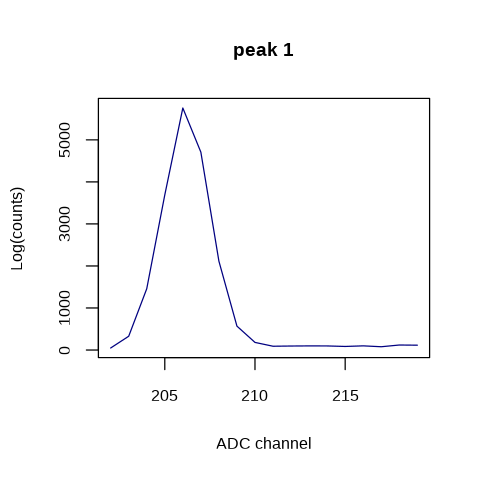

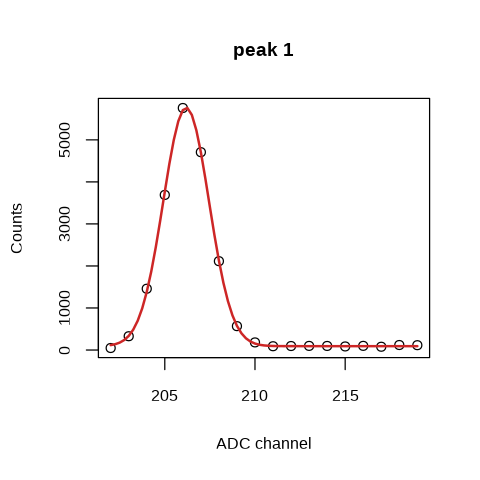

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
A  7378.320 55.572214 1.0146052      1.0830318
B   190.114  3.055480 0.0557852      0.0537307
w     1.543  0.007984 0.0001458      0.0001458
x0  542.816  0.009718 0.0001774      0.0001774

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  7268.655 7339.690 7379.019 7415.335 7491.437
B   184.142  188.082  190.137  192.087  196.017
w     1.527    1.537    1.543    1.548    1.558
x0  542.796  542.809  542.816  542.822  542.835



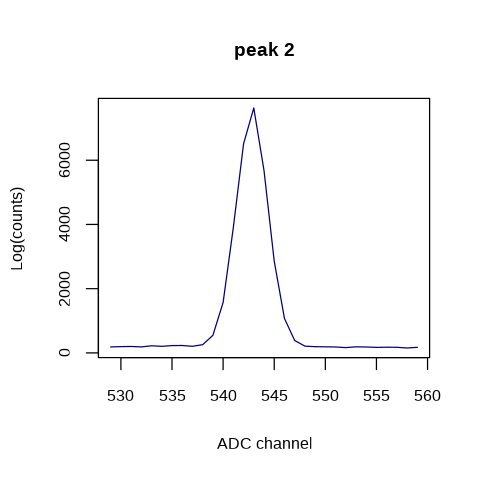

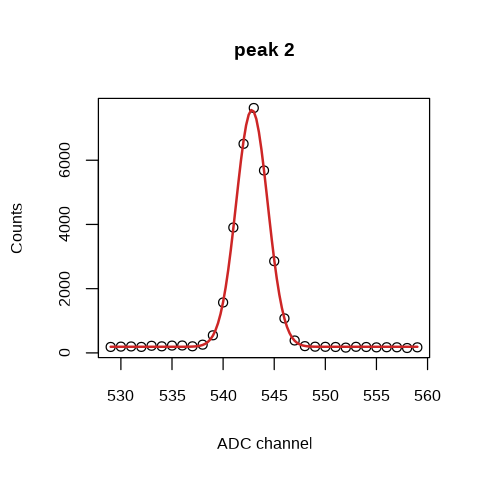

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  2637.532 30.84349 0.5631225      0.5626555
B   150.451  3.69795 0.0675149      0.0659191
w     1.649  0.01567 0.0002862      0.0002863
x0  968.728  0.01808 0.0003300      0.0003223

2. Quantiles for each variable:

       2.5%      25%      50%      75%   97.5%
A  2575.176 2616.558 2638.737 2659.898 2692.60
B   143.428  147.859  150.470  152.861  157.78
w     1.619    1.638    1.649    1.659    1.68
x0  968.692  968.717  968.728  968.740  968.76



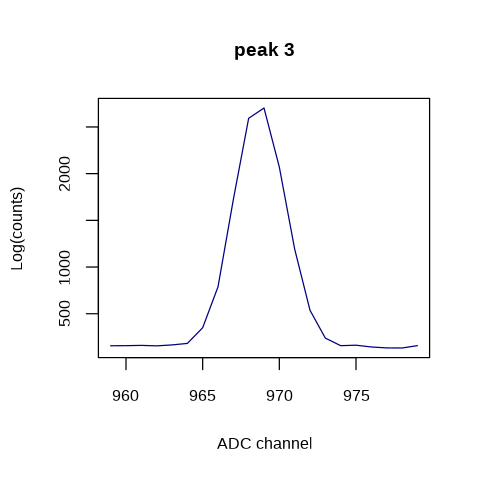

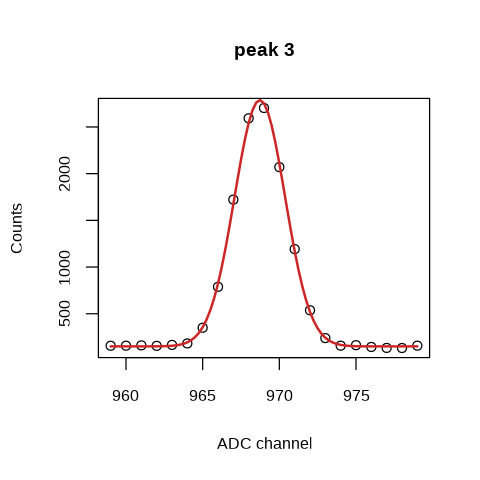

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  2227.836 29.88752 0.5456689      0.5567338
B   114.331  1.94043 0.0354272      0.0341669
w     1.769  0.01721 0.0003143      0.0003238
x0 1102.445  0.02064 0.0003769      0.0003703

2. Quantiles for each variable:

       2.5%      25%      50%     75%    97.5%
A  2170.152 2207.568 2227.449 2248.03 2287.583
B   110.547  113.008  114.330  115.61  118.245
w     1.737    1.757    1.768    1.78    1.803
x0 1102.405 1102.431 1102.445 1102.46 1102.485



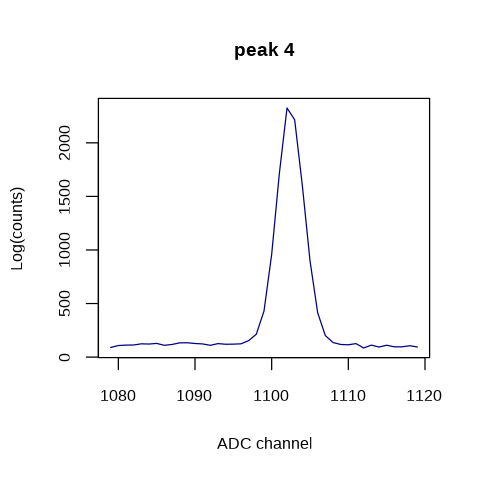

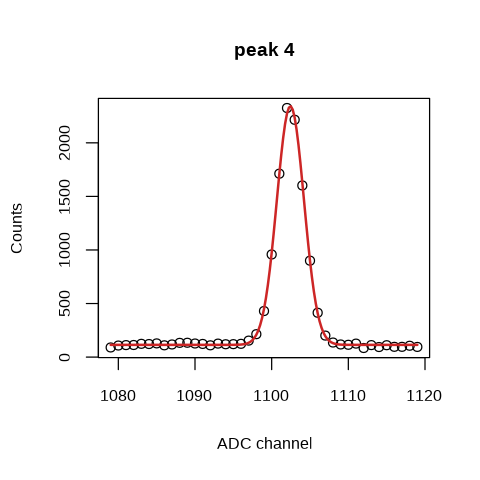

In [60]:
i=1
chains <-c()
x0_mean <-c()
x0_std <-c()
for (pk in peaks){

#Plot of the choosen peak
set_plot_dimensions(4, 4)
plot(pk$x,pk$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel",
    main=paste("peak",i))

A.min <- min(pk$y)
A.max <- max(pk$y)
B.min <- 0
B.max <- min(pk$y)   #This is a critical point for peaks that doesn't have a
                     #a stable noise around so min(pk$y) is not representative
x0.min <- min(pk$x)  
x0.max <- max(pk$x)

cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dunif(",A.min,",",A.max,")
    B ~ dunif(",B.min,",",B.max*2,")

    x0 ~ dunif(",x0.min,",",x0.max,")
    w ~ dunif(1,10)
      
}", file=paste("Models/model_peak_",i,".bug",sep=""))

model <- paste("Models/model_peak_",i,".bug",sep="")


#If multiple chains are run, each of them need to be initialized
init <- NULL;init$A  <- (A.max-A.min)/2
init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

#To have absolute control we also set the seed for and random number generator for each chain
init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10


jm <- jags.model(model,
                 pk,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
chains <- append(chains,list(chain))

#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
#plot(chain)
print(paste("peak",i))
print(summary(chain))

A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x0_mean <- c(x0_mean,x0)
x0_std <- c(x0_std,summary(chain)$statistics[4,2])  
    
x <- seq(x0.min,x0.max,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


set_plot_dimensions(4, 4)
plot(pk$x,pk$y,
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')
i=i+1
}

#### Americum

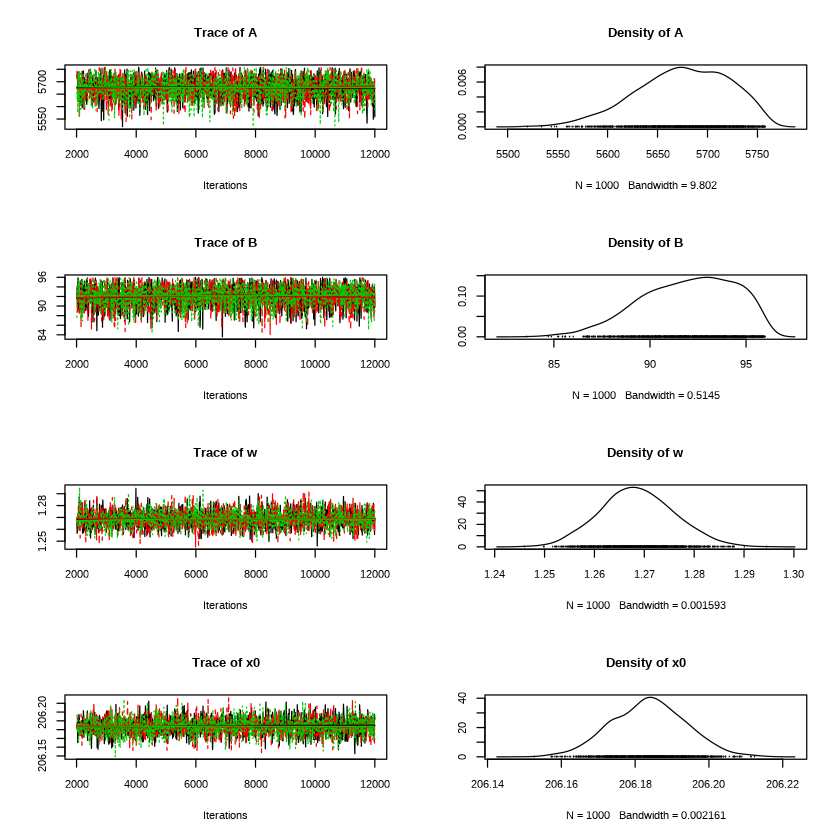

In [61]:
set_plot_dimensions(7, 7)
plot(chains[[1]])

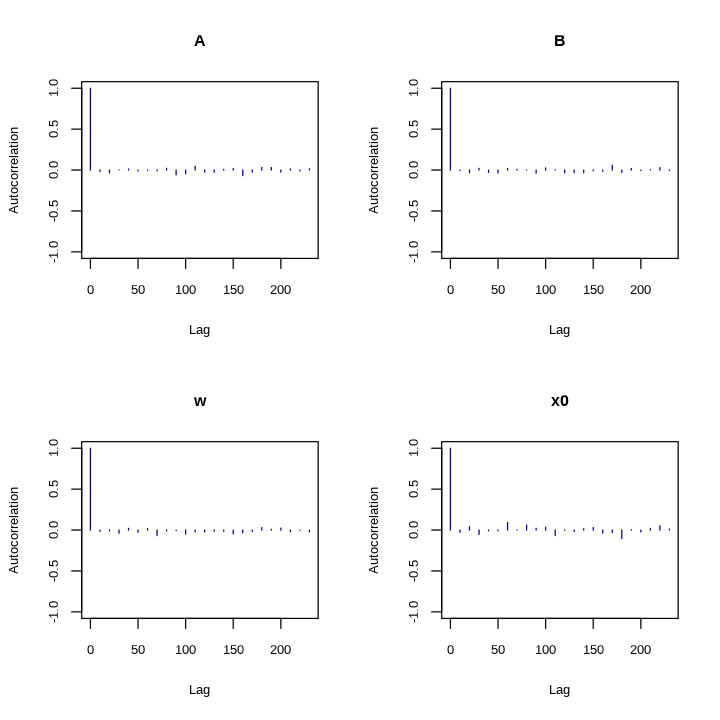

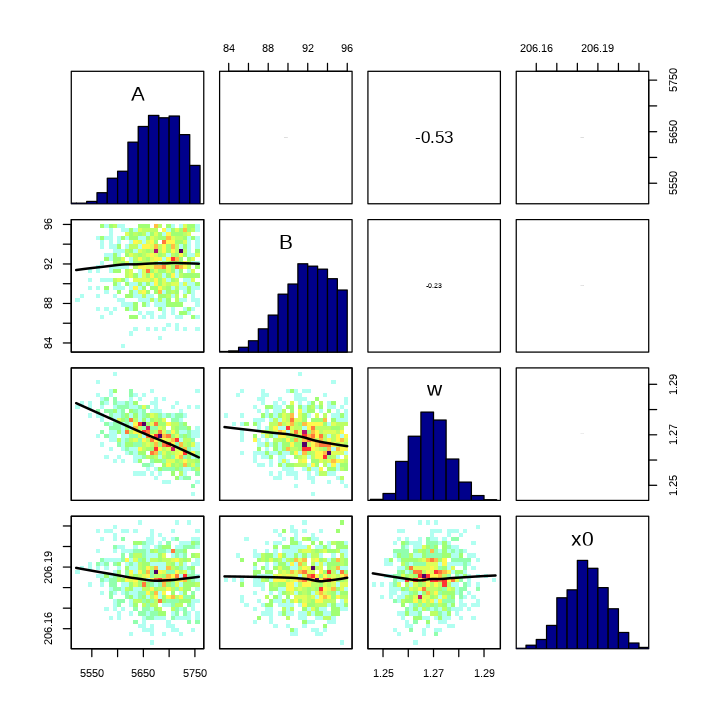

In [62]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[1]][1], col='navy')

correlationPlot((chains[[1]]))

#### Cs

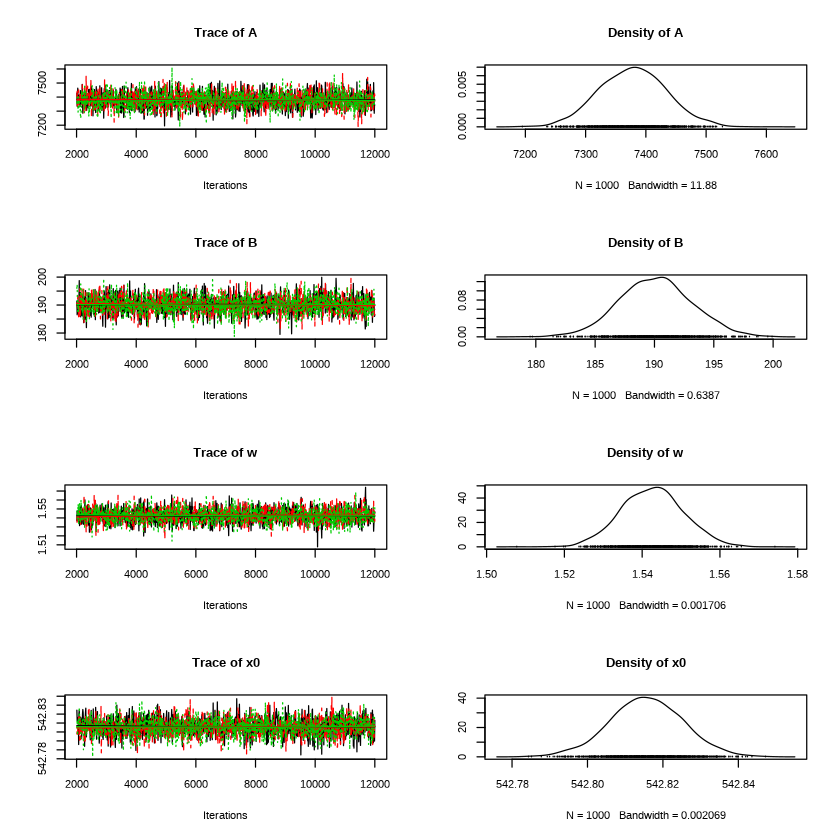

In [63]:
set_plot_dimensions(7, 7)
plot(chains[[2]])

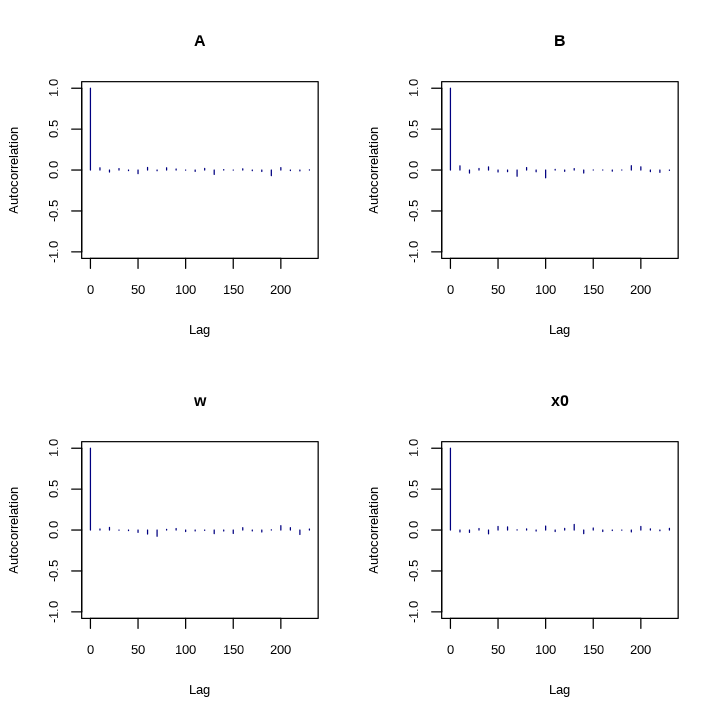

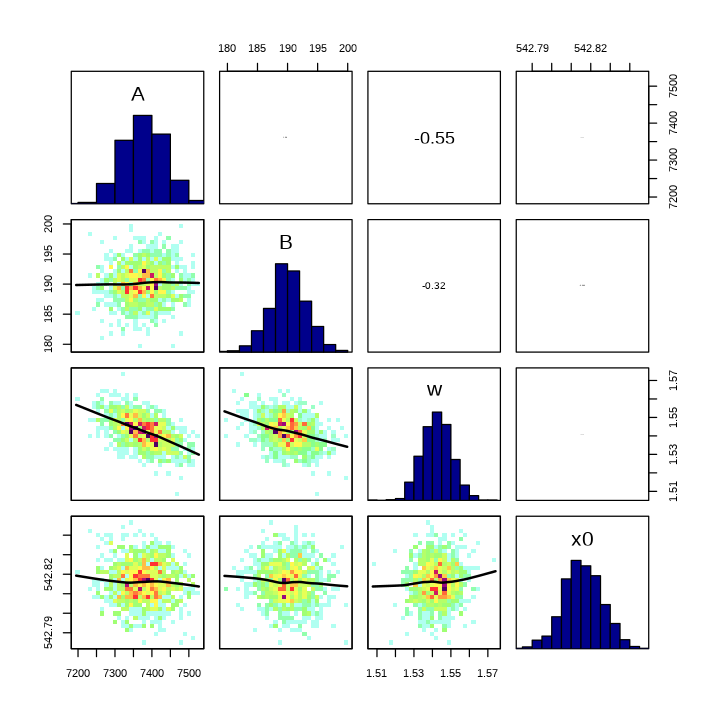

In [64]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[2]][1], col='navy')

correlationPlot((chains[[2]]))

### Co 1

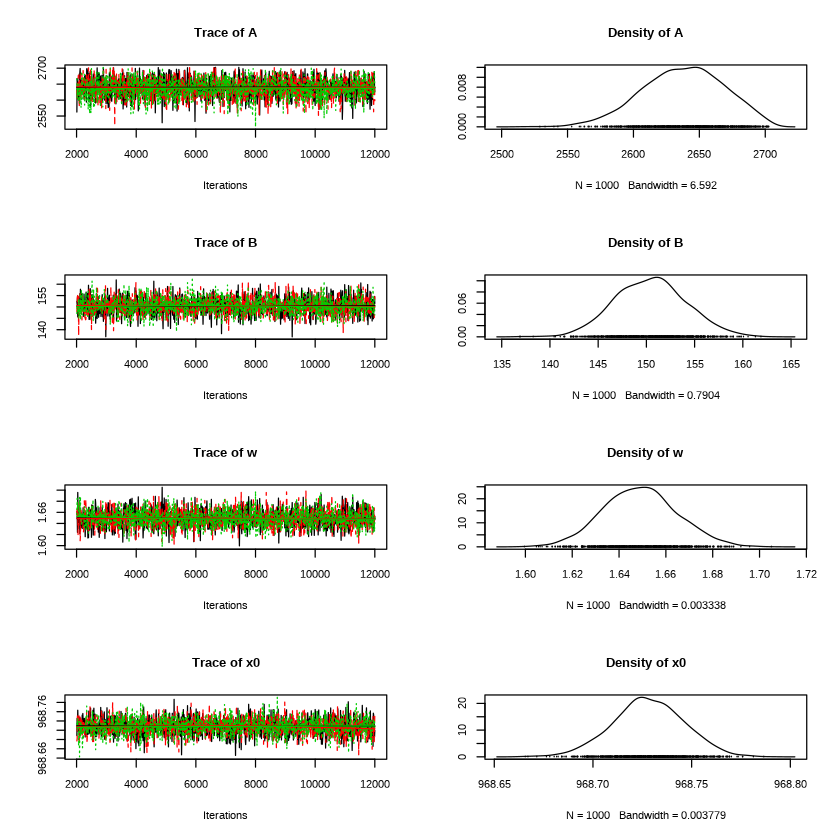

In [65]:
set_plot_dimensions(7, 7)
plot(chains[[3]])

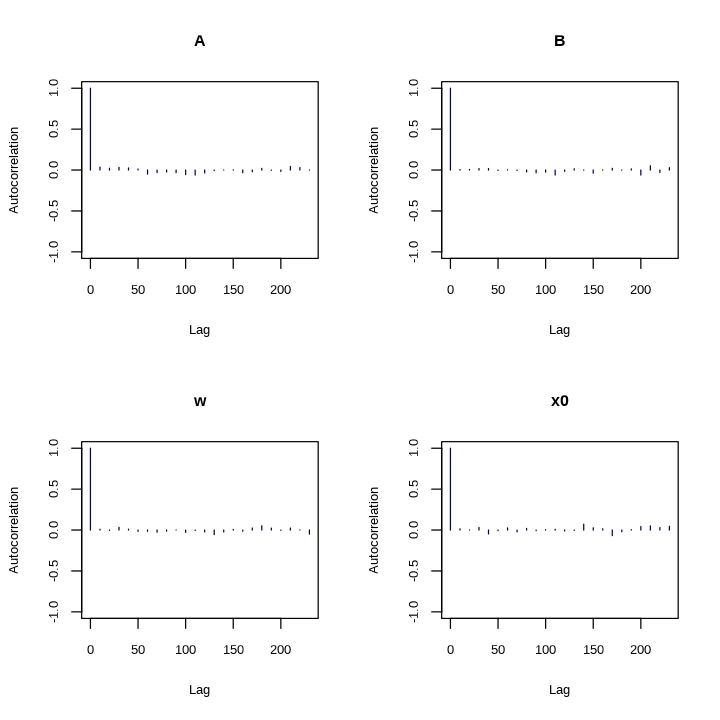

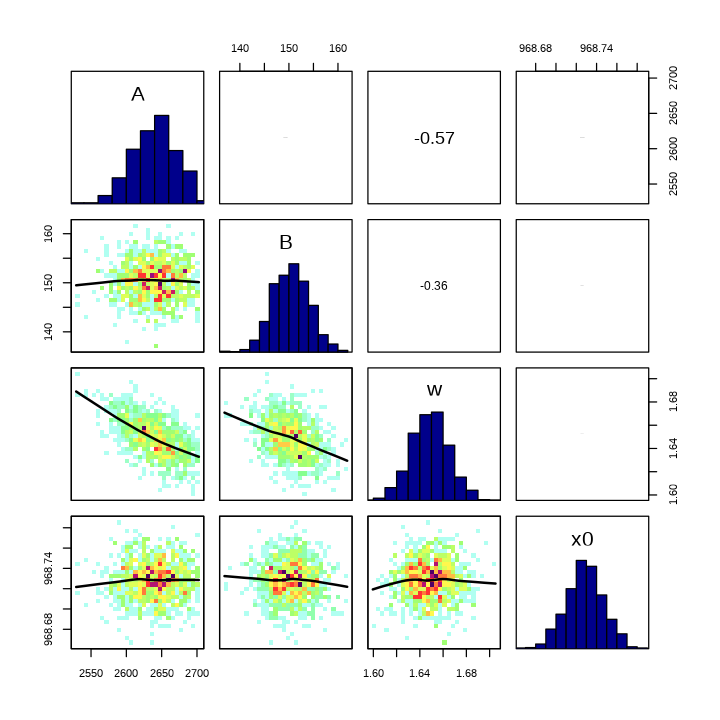

In [66]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[3]][1], col='navy')

correlationPlot((chains[[3]]))

#### Co 2

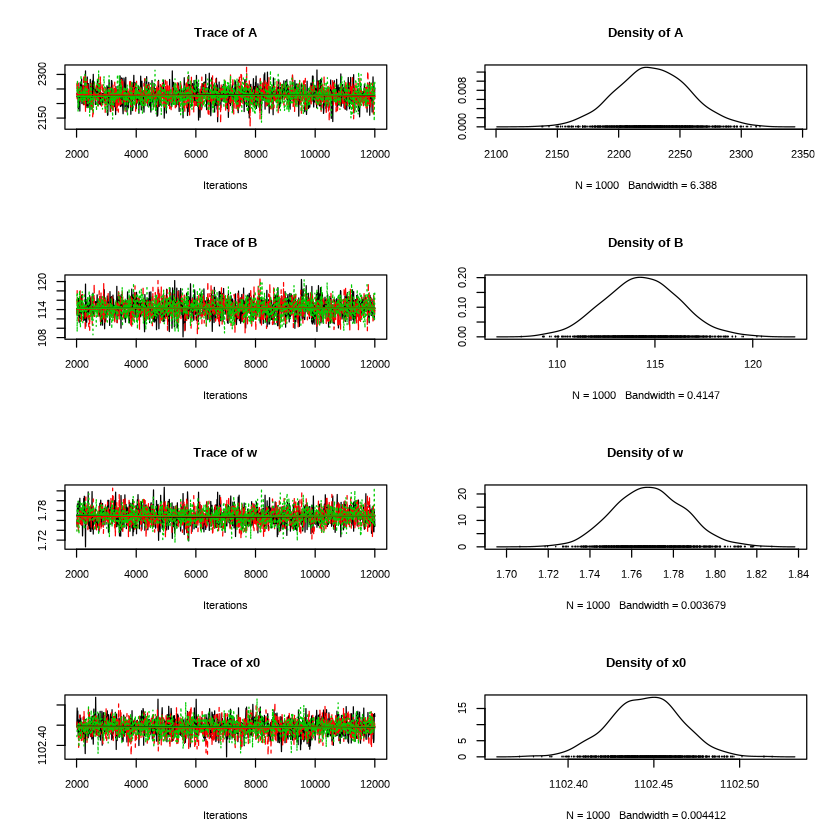

In [67]:
set_plot_dimensions(7, 7)
plot(chains[[4]])

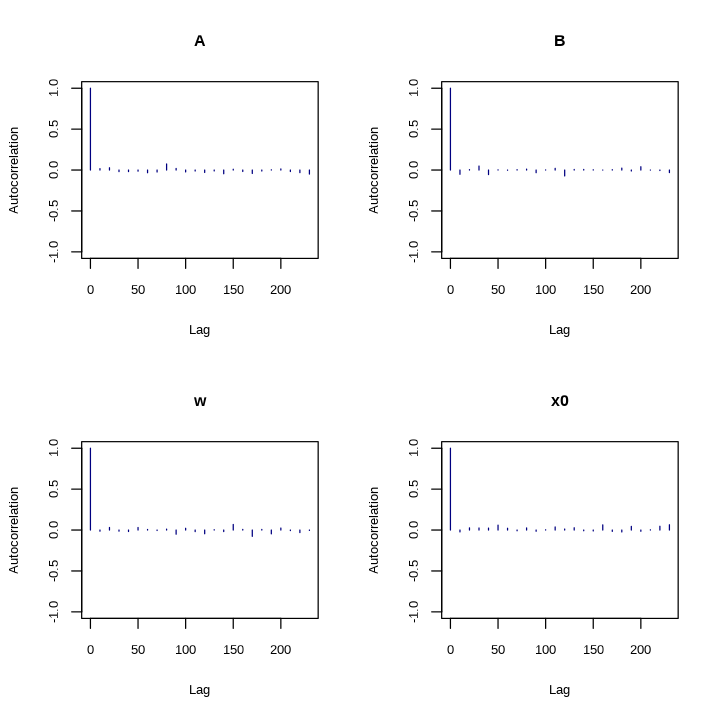

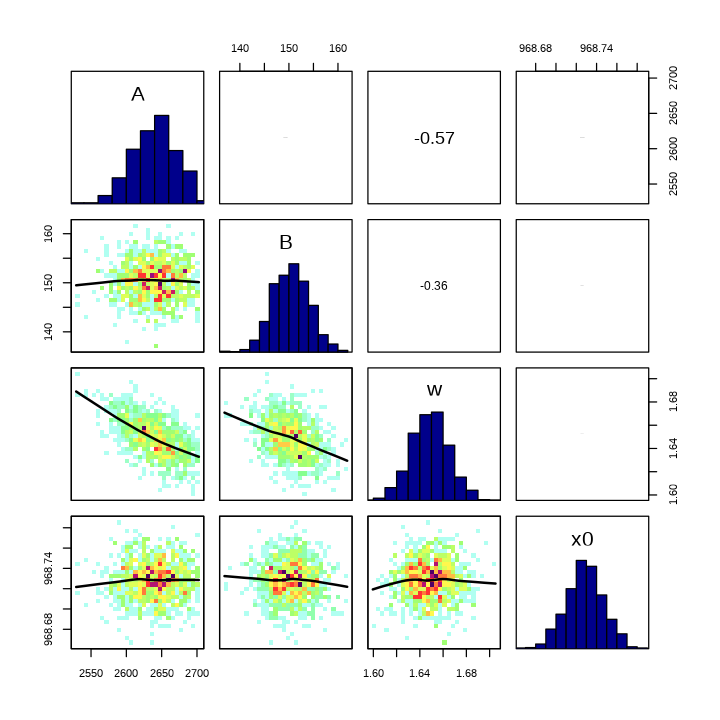

In [68]:
set_plot_dimensions(6, 6)
autocorr.plot(chains[[4]][1], col='navy')

correlationPlot((chains[[3]]))

## Energy calibration

In [69]:
peak_energy <-c(59.5409,661.657,1173.228,1332.51)


In [70]:
df <- data.frame(peak_energy,x0_mean,x0_std)
row.names(df)<-c("Am","Cs","Co_1","Co_2")

In [71]:
df

,peak_energy,x0_mean,x0_std
Am,59.5409,206.1837,0.010108613
Cs,661.6570,542.8156,0.009717546
Co_1,1173.2280,968.7281,0.018075044
Co_2,1332.5100,1102.4449,0.020643570


In [72]:
linear_fit <- lm( df$peak_energy ~ df$x0_mean )

intercept <- as.numeric(linear_fit$coefficients[1])
slope <- as.numeric(linear_fit$coefficients[2])
ln <- intercept + data$Ch*slope

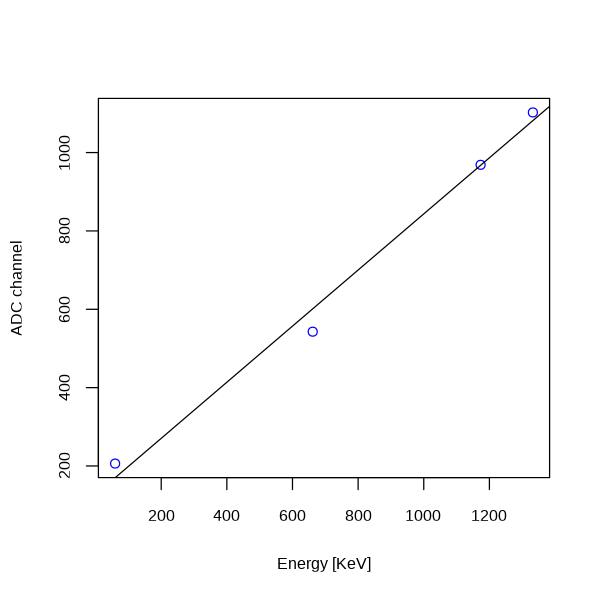

In [73]:
set_plot_dimensions(5, 5)
plot(df$peak_energy,df$x0_mean,col="blue",
    xlab="Energy [KeV]",ylab="ADC channel",
    main="")
lines(ln,data$Ch)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

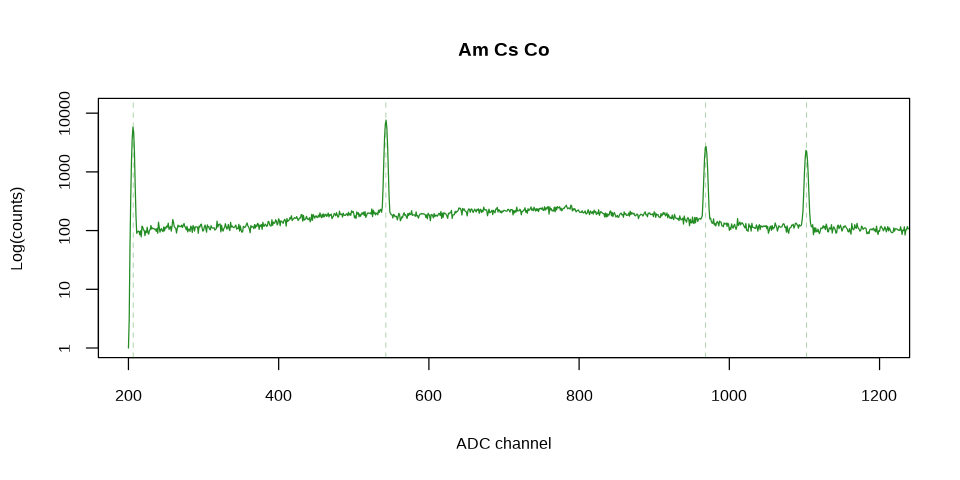

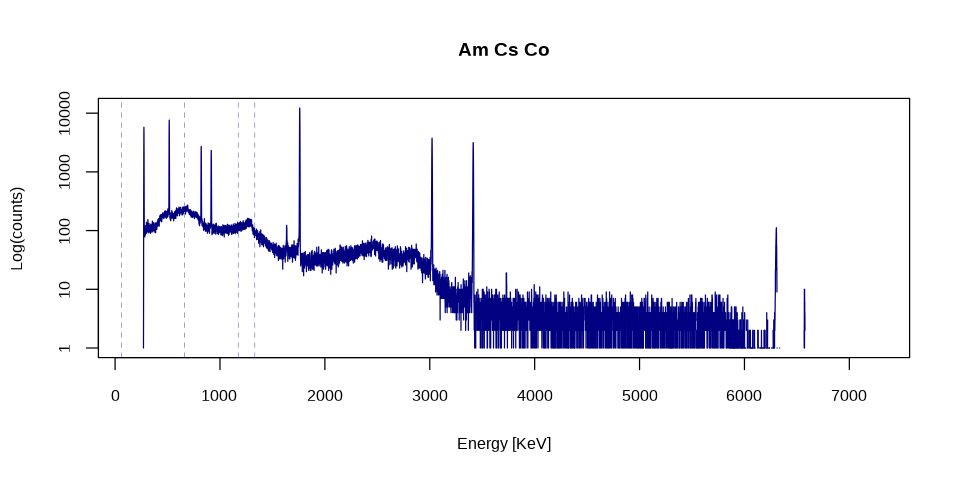

In [76]:
set_plot_dimensions(8, 4)

energy <- (data$Ch-intercept)/slope
xmin<-200;xmax<-1200
emin<-(xmin-intercept)/slope;emax<- (xmax-intercept)/slope

plot(data$Ch,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
abline(v=x0_mean[1],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[2],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[3],col="forestgreen",lty=2,lwd=0.3)
abline(v=x0_mean[4],col="forestgreen",lty=2,lwd=0.3)

e0_mean <- (x0_mean-intercept)/slope

plot(energy,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",

    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
abline(v=peak_energy[1],col="navy",lty=2,lwd=0.3)
abline(v=peak_energy[2],col="navy",lty=2,lwd=0.3)
abline(v=peak_energy[3],col="navy",lty=2,lwd=0.3)
abline(v=peak_energy[4],col="navy",lty=2,lwd=0.3)

## Resolution study

In [45]:
e0_mean

[1] 274.9614 516.0390 821.0545 916.8152